In [504]:
spark.stop()

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Query-local-fidelity" data-toc-modified-id="Query-local-fidelity-1">Query-local fidelity</a></span></li><li><span><a href="#Rank-difference-local-fidelity" data-toc-modified-id="Rank-difference-local-fidelity-2">Rank-difference-local fidelity</a></span></li><li><span><a href="#Query--and-rank-difference-local-fidelity" data-toc-modified-id="Query--and-rank-difference-local-fidelity-3">Query- and rank-difference-local fidelity</a></span></li><li><span><a href="#Including-ranking-based-features-in-a-query-local-model" data-toc-modified-id="Including-ranking-based-features-in-a-query-local-model-4">Including ranking-based features in a query-local model</a></span><ul class="toc-item"><li><span><a href="#(a)-only-ranking-difference" data-toc-modified-id="(a)-only-ranking-difference-4.1">(a) only ranking difference</a></span></li><li><span><a href="#(b)-ranking-difference-plus-position" data-toc-modified-id="(b)-ranking-difference-plus-position-4.2">(b) ranking difference plus position</a></span></li><li><span><a href="#(c)-score-difference-plus-upper_score" data-toc-modified-id="(c)-score-difference-plus-upper_score-4.3">(c) score difference plus upper_score</a></span></li><li><span><a href="#(d)-all-ranking-+-score-features" data-toc-modified-id="(d)-all-ranking-+-score-features-4.4">(d) all ranking + score features</a></span></li></ul></li><li><span><a href="#Including-ranking-based-features-in-rank-diff-local-model" data-toc-modified-id="Including-ranking-based-features-in-rank-diff-local-model-5">Including ranking-based features in rank-diff local model</a></span></li><li><span><a href="#Including-ranking-based-features-in-mixed-model" data-toc-modified-id="Including-ranking-based-features-in-mixed-model-6">Including ranking-based features in mixed model</a></span></li><li><span><a href="#Binning-by-upper-rank" data-toc-modified-id="Binning-by-upper-rank-7">Binning by upper-rank</a></span><ul class="toc-item"><li><span><a href="#One-model-per-upper-rank-bin" data-toc-modified-id="One-model-per-upper-rank-bin-7.1">One model per upper-rank bin</a></span></li><li><span><a href="#One-model-per-upper-rank-bin-with-rank-dependent-features" data-toc-modified-id="One-model-per-upper-rank-bin-with-rank-dependent-features-7.2">One model per upper-rank bin with rank-dependent features</a></span></li><li><span><a href="#One-model-per-(query,-upper-rank-bin)-pair" data-toc-modified-id="One-model-per-(query,-upper-rank-bin)-pair-7.3">One model per (query, upper-rank bin) pair</a></span></li><li><span><a href="#One-model-per-(query,-upper-rank-bin)-pair-with-rank-dependent-features" data-toc-modified-id="One-model-per-(query,-upper-rank-bin)-pair-with-rank-dependent-features-7.4">One model per (query, upper-rank bin) pair with rank-dependent features</a></span></li></ul></li></ul></div>

##### (common setup stuff)

In [502]:
%run -i experiments_common.py

In [505]:
%%time
os.environ['PYSPARK_PYTHON'] = 'python3.6'
os.environ['HADOOP_CONF_DIR'] = os.path.join(os.environ['HOME'], 'aitools4-aq-cluster-computing/conf/hadoop')

sparkconf = SparkConf()

n_exc = 160
cores = 16

mode = 'standalone'

if mode == 'yarn':
    (sparkconf.setMaster('yarn')
      .set('spark.driver.memory', '32g')
      .set('spark.driver.maxResultSize', '2g')
      .set('spark.executor.memory', '64g')
     .set('spark.executor.cores', str(cores))
     .set('spark.executor.instances', str(n_exc))
     .set('spark.default.parallelism', str(n_exc*cores))
    )
elif mode == 'standalone':
    (sparkconf.setMaster('spark://betaweb020.medien.uni-weimar.de:7077')
      .set('spark.driver.memory', '32g')
      .set('spark.driver.maxResultSize', '2g')
     .set('spark.default.parallelism', str(129*12))
    )
                    
global spark

if 'spark' in globals() and hasattr(spark, 'stop'):
    spark.stop()
    SparkSession._instantiatedContext = None
    
spark = SparkSession.builder.config(conf=sparkconf).getOrCreate()

spark

CPU times: user 20 ms, sys: 16 ms, total: 36 ms
Wall time: 270 ms


In [450]:
%%time
dataset_path = 'axexp/prefs/2019-05-01_uniform-samples_21-axioms.jsonl'
dataset_sparkdf = spark.read.json(dataset_path)
col_predictors = [x for x in dataset_sparkdf.columns if x.startswith('ax_')]
col_response = 'concordant'

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 8.14 s


In [451]:
# classifier template
make_classifier = lambda: sklearn.ensemble.RandomForestClassifier(max_depth=20, n_estimators=128)

serialize_model = lambda m: base64.b64encode(pickle.dumps(m))
deserialize_model = lambda b64: pickle.loads(base64.b64decode(b64))

In [452]:
dataset_sparkdf.printSchema()

root
 |-- ax_AND: long (nullable = true)
 |-- ax_DIV: long (nullable = true)
 |-- ax_LB1: long (nullable = true)
 |-- ax_LNC1: long (nullable = true)
 |-- ax_M_AND: long (nullable = true)
 |-- ax_M_TDC: long (nullable = true)
 |-- ax_PROX1: long (nullable = true)
 |-- ax_PROX2: long (nullable = true)
 |-- ax_PROX3: long (nullable = true)
 |-- ax_PROX4: long (nullable = true)
 |-- ax_PROX5: long (nullable = true)
 |-- ax_REG: long (nullable = true)
 |-- ax_STMC1: long (nullable = true)
 |-- ax_STMC1_f: long (nullable = true)
 |-- ax_STMC1_fr: long (nullable = true)
 |-- ax_STMC2: long (nullable = true)
 |-- ax_STMC2_f: long (nullable = true)
 |-- ax_STMC2_fr: long (nullable = true)
 |-- ax_TFC1: long (nullable = true)
 |-- ax_TFC3: long (nullable = true)
 |-- ax_TF_LNC: long (nullable = true)
 |-- concordant: long (nullable = true)
 |-- query: string (nullable = true)
 |-- rankdiff: long (nullable = true)
 |-- scorediff: double (nullable = true)
 |-- system: string (nullable = true)
 |-

In [453]:
def mk_fit_fn(group_key, keep_model=False, features=list(col_predictors), num_cv_folds=10):
    
    output_schema = [
        T.StructField(fn, T.StringType(), False) for fn in group_key
    ] + [
        T.StructField('cv_accuracy_mean', T.FloatType(), False),
        T.StructField('cv_accuracy_std', T.FloatType(), False),
        T.StructField('avg_train_samples_per_fold', T.FloatType(), False),
        T.StructField('avg_test_samples_per_fold', T.FloatType(), False),
        T.StructField('feature_importances', T.ArrayType(T.FloatType(), False))
    ]
    
    
    
    if keep_model:
        output_schema.append(T.StructField('model', T.StringType(), False))    
    
    output_schema = T.StructType(output_schema)
    
    
    @pandas_udf(output_schema, PandasUDFType.GROUPED_MAP)
    def fit(pdf):
        """Fit a sub-model on a partial dataframe while recording CV scores."""
        xs = pdf[features].values
        ys = pdf[col_response]
        group = list(pdf[group_key].iloc[0])
        columns = group_key + ['cv_accuracy_mean', 'cv_accuracy_std', 'avg_train_samples_per_fold', 'avg_test_samples_per_fold', 'feature_importances']

        if keep_model:
            columns.append('model')
        
        clf = make_classifier()
        #scores = cross_val_score(clf, xs, ys, cv=num_cv_folds)

        splits = GroupShuffleSplit(n_splits=num_cv_folds, random_state=0, test_size=(1/num_cv_folds))
        split_groups = pdf.upper_rank.map(str) + '-' + pdf.rankdiff.map(str)
        scores = cross_val_score(clf, xs, ys, cv=splits.split(xs, ys, split_groups))
        sample_sizes = np.array([[len(tr), len(ts)] for tr, ts in splits.split(xs, ys, split_groups)])
        avg_ntr, avg_nts = sample_sizes.mean(axis=0)

        full_model = clf.fit(xs, ys)
        fimps = pd.Series(data=full_model.feature_importances_, index=features)
        out =  pd.DataFrame([
            group + [scores.mean(), scores.std(), avg_ntr, avg_nts, fimps] + ([serialize_model(full_model)] if keep_model else []) ],
            columns=columns
        )

        return out
    return fit

def feature_importances(df, group_key, features=list(col_predictors)):
    s = df.feature_importances.map(lambda a: dict(zip(features, a)))
    s = pd.DataFrame(list(s))
    s = pd.concat([df, s], axis=1)
    s = s.melt(id_vars=group_key, value_vars=features, var_name='feature', value_name='importance')
    s['feature'] = s.feature.map(lambda fname: fname.replace('ax_', ''))
    return s
    

# Query-local fidelity

Split training data by (query, system) -- i.e. for each system, train one model per query.

In [454]:
%%time
df = dataset_sparkdf
#df = df[(df.query == '356') & (df.system == 'DRMM')]
query_system = ['query', 'system']
fit = mk_fit_fn(group_key=query_system, keep_model=False)
query_local_stats = df.groupBy(query_system).apply(fit).toPandas()

CPU times: user 52 ms, sys: 28 ms, total: 80 ms
Wall time: 56.5 s


In [455]:
record_fidelity_experiment(query_local_stats, 'loc_q', 'Local', 'query', features=col_predictors)
query_local_stats.groupby('system').describe().T

system                                   DRMM       MP-COS   PACRR-DRMM
cv_accuracy_mean           count   100.000000   100.000000   100.000000
                           mean      0.682767     0.665992     0.721966
                           std       0.060840     0.068857     0.068956
                           min       0.568102     0.549217     0.594325
                           25%       0.633146     0.612451     0.668909
                           50%       0.678033     0.654746     0.719569
                           75%       0.729452     0.711595     0.777446
                           max       0.821918     0.834834     0.871816
cv_accuracy_std            count   100.000000   100.000000   100.000000
                           mean      0.016865     0.016760     0.015226
                           std       0.004035     0.003816     0.003484
                           min       0.007564     0.008377     0.007018
                           25%       0.013859     0.014359     0.012933
                           50%       0.017068     0.017046     0.015151
                           75%       0.019381     0.019060     0.016956
                           max       0.025926     0.025444     0.024135
avg_train_samples_per_fold count   100.000000   100.000000   100.000000
                           mean   9199.360352  9199.360352  9199.360352
                           std      52.122528    52.122528    52.122528
                           min    9192.000000  9192.000000  9192.000000
                           25%    9192.000000  9192.000000  9192.000000
                           50%    9192.000000  9192.000000  9192.000000
                           75%    9192.000000  9192.000000  9192.000000
                           max    9602.000000  9602.000000  9602.000000
avg_test_samples_per_fold  count   100.000000   100.000000   100.000000
                           mean   1022.820007  1022.820007  1022.820007
                           std       5.812526     5.812526     5.812526
                           min    1022.000000  1022.000000  1022.000000
                           25%    1022.000000  1022.000000  1022.000000
                           50%    1022.000000  1022.000000  1022.000000
                           75%    1022.000000  1022.000000  1022.000000
                           max    1068.000000  1068.000000  1068.000000

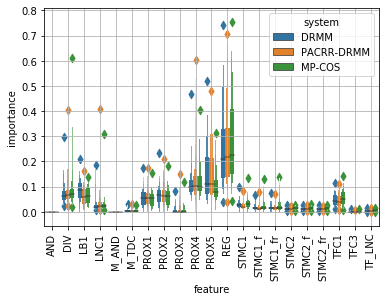

In [456]:
qlm_fimp = feature_importances(query_local_stats, group_key=query_system)
p = sns.boxenplot(data=qlm_fimp, x='feature', y='importance', hue='system')
p.set_xticklabels(p.get_xticklabels(), rotation=90);
plt.grid()

# Rank-difference-local fidelity

Split data by (system, rank-difference-bin) -- for each system, train one model per rank difference bin

[  1.   8.  21.  42.  65.  87. 111. 135. 160. 182. 208. 238. 267. 298.
 328. 358. 398. 435. 476. 515. 570. 626. 689. 783. 989.]
42592.4 pairs per bin on average.


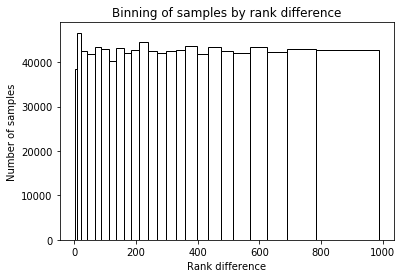

In [457]:
rdiffs = dataset_sparkdf.where('system = "DRMM"').select('rankdiff').toPandas()
from scipy import stats
bin_edges = stats.mstats.mquantiles(
    rdiffs.rankdiff, np.linspace(0,1,25))
print(bin_edges)
plt.hist(rdiffs.rankdiff, bin_edges, color='w', edgecolor='k')
plt.title('Binning of samples by rank difference')
plt.xlabel('Rank difference')
plt.ylabel('Number of samples')
bin_edges = bin_edges[1:]
rdiffs['bin'] = rdiffs.rankdiff.map(lambda rd: bin_edges.searchsorted(rd))
print(f'{rdiffs.groupby("bin").count().mean().iloc[0]:.1f} pairs per bin on average.')

In [458]:
system_rankdiff = ['system', 'rankdiff_bin']

rd_udf = udf(lambda r: int(bin_edges.searchsorted(r)), returnType='byte')

fit_binned = mk_fit_fn(system_rankdiff)

rdiff_models = dataset_sparkdf.withColumn('rankdiff_bin', rd_udf('rankdiff')).groupBy(system_rankdiff).apply(fit_binned)


In [459]:
%%time
rdm_stats = rdiff_models.drop('model').toPandas()

CPU times: user 60 ms, sys: 28 ms, total: 88 ms
Wall time: 1min 51s


In [460]:
record_fidelity_experiment(rdm_stats, 'loc_rd', 'Local', 'rank-diff bin', features=col_predictors)
rdm_stats.groupby('system').describe().T

system                                    DRMM        MP-COS    PACRR-DRMM
cv_accuracy_mean           count     24.000000     24.000000     24.000000
                           mean       0.611702      0.588207      0.672749
                           std        0.062990      0.055134      0.080707
                           min        0.522934      0.502959      0.537695
                           25%        0.559825      0.548322      0.614150
                           50%        0.611066      0.581986      0.678422
                           75%        0.642341      0.624200      0.733326
                           max        0.763567      0.715724      0.824003
cv_accuracy_std            count     24.000000     24.000000     24.000000
                           mean       0.010766      0.010948      0.011307
                           std        0.003393      0.002964      0.004405
                           min        0.005458      0.005642      0.005879
                           25%        0.008585      0.008449      0.009085
                           50%        0.010429      0.011049      0.010613
                           75%        0.012152      0.013122      0.012505
                           max        0.021117      0.016372      0.027354
avg_train_samples_per_fold count     24.000000     24.000000     24.000000
                           mean   38219.339844  38219.339844  38219.339844
                           std      687.915649    687.915649    687.915649
                           min    36812.800781  36812.800781  36812.800781
                           25%    37843.899414  37843.899414  37843.899414
                           50%    38220.000000  38220.000000  38220.000000
                           75%    38704.351562  38704.351562  38704.351562
                           max    39419.199219  39419.199219  39419.199219
avg_test_samples_per_fold  count     24.000000     24.000000     24.000000
                           mean    4373.074707   4373.074707   4373.074707
                           std      150.615097    150.615097    150.615097
                           min     4028.800049   4028.800049   4028.800049
                           25%     4312.000000   4312.000000   4312.000000
                           50%     4312.000000   4312.000000   4312.000000
                           75%     4423.849976   4423.849976   4423.849976
                           max     4717.600098   4717.600098   4717.600098

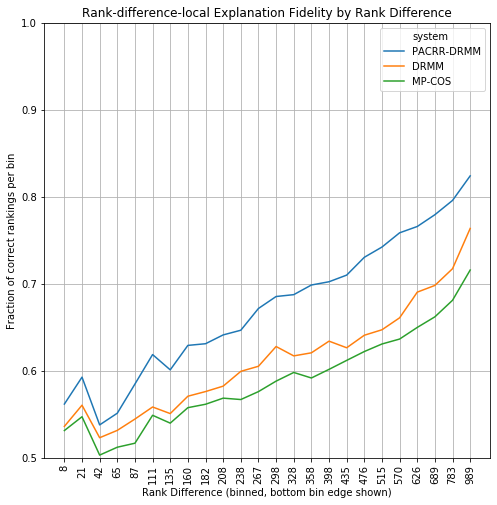

In [461]:
sns.lineplot(data=rdm_stats, x='rankdiff_bin', y='cv_accuracy_mean', hue='system')
bin_labels = ['%.0f'%x for x in bin_edges]
plt.xticks(np.arange(len(bin_labels)), bin_labels, rotation=90)
plt.xlabel('Rank Difference (binned, bottom bin edge shown)')
plt.ylabel('Fraction of correct rankings per bin')
plt.title('Rank-difference-local Explanation Fidelity by Rank Difference')
plt.ylim((0.5,1));
plt.gcf().set_size_inches((8,8))
plt.grid();

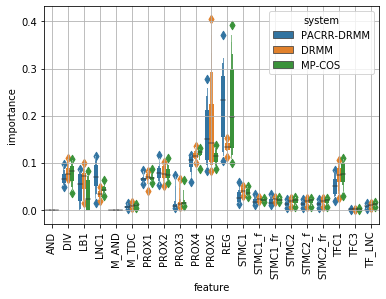

In [462]:
rdm_fimp = feature_importances(rdm_stats, system_rankdiff)
p = sns.boxenplot(data=rdm_fimp, x='feature', y='importance', hue='system')
p.set_xticklabels(p.get_xticklabels(), rotation=90);
plt.grid()

# Query- and rank-difference-local fidelity

split data by (system, query, rank-difference-bin)

[  1.      8.     21.     42.     67.     90.    115.    139.    163.
 188.    214.    245.    274.    303.    335.    367.275 403.    440.
 480.    520.    575.    631.    693.    785.    989.   ]
425.6 pairs per bin on average.


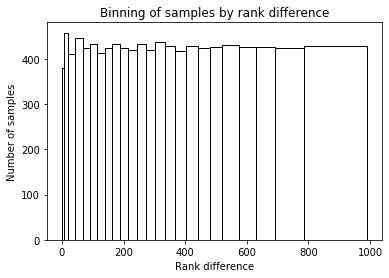

In [463]:
rdiffs = dataset_sparkdf.where('system = "DRMM" and query = 301').select('rankdiff').toPandas()
from scipy import stats
bin_edges = stats.mstats.mquantiles(
    rdiffs.rankdiff, np.linspace(0,1,25))
print(bin_edges)
plt.hist(rdiffs.rankdiff, bin_edges, color='w', edgecolor='k')
plt.title('Binning of samples by rank difference')
plt.xlabel('Rank difference')
plt.ylabel('Number of samples')
bin_edges = bin_edges[1:]
rdiffs['bin'] = rdiffs.rankdiff.map(lambda rd: bin_edges.searchsorted(rd))
print(f'{rdiffs.groupby("bin").count().mean().iloc[0]:.1f} pairs per bin on average.')

In [464]:
query_system_rankdiff = ['query', 'system', 'rankdiff_bin']

rd_udf = udf(lambda r: int(bin_edges.searchsorted(r)), returnType='byte')
fit_binned = mk_fit_fn(query_system_rankdiff)

query_rdiff_models = dataset_sparkdf.withColumn('rankdiff_bin', rd_udf('rankdiff')).groupBy(query_system_rankdiff).apply(fit_binned)


In [465]:
%%time
qrdm_stats = query_rdiff_models.drop('model').toPandas()

CPU times: user 160 ms, sys: 52 ms, total: 212 ms
Wall time: 2min 43s


In [466]:
record_fidelity_experiment(qrdm_stats, 'loc_q_rd', 'Local', 'query, rank-diff bin', features=col_predictors)
qrdm_stats.groupby('system').describe().T

system                                   DRMM       MP-COS   PACRR-DRMM
cv_accuracy_mean           count  2383.000000  2383.000000  2383.000000
                           mean      0.663485     0.645647     0.699166
                           std       0.135900     0.134821     0.145498
                           min       0.368182     0.347727     0.384091
                           25%       0.561364     0.545455     0.581818
                           50%       0.638095     0.618182     0.679545
                           75%       0.747727     0.725595     0.806818
                           max       1.000000     1.000000     1.000000
cv_accuracy_std            count  2383.000000  2383.000000  2383.000000
                           mean      0.079128     0.080503     0.075753
                           std       0.023890     0.023814     0.025905
                           min       0.000000     0.000000     0.000000
                           25%       0.064483     0.065121     0.059656
                           50%       0.079513     0.080707     0.076871
                           75%       0.094297     0.096451     0.093735
                           max       0.164831     0.170184     0.153540
avg_train_samples_per_fold count  2383.000000  2383.000000  2383.000000
                           mean    385.125458   385.125458   385.125458
                           std      41.492523    41.492523    41.492523
                           min      54.000000    54.000000    54.000000
                           25%     378.000000   378.000000   378.000000
                           50%     382.000000   382.000000   382.000000
                           75%     386.000000   386.000000   386.000000
                           max    1124.000000  1124.000000  1124.000000
avg_test_samples_per_fold  count  2383.000000  2383.000000  2383.000000
                           mean     43.837181    43.837181    43.837181
                           std       4.663344     4.663344     4.663344
                           min       6.000000     6.000000     6.000000
                           25%      42.000000    42.000000    42.000000
                           50%      44.000000    44.000000    44.000000
                           75%      44.000000    44.000000    44.000000
                           max     126.000000   126.000000   126.000000

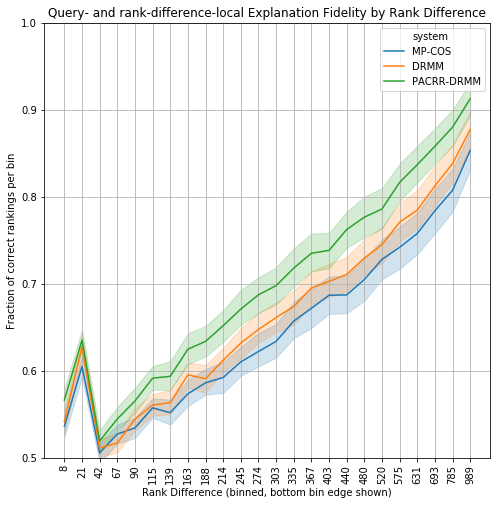

In [467]:
sns.lineplot(data=qrdm_stats, x='rankdiff_bin', y='cv_accuracy_mean', hue='system')
bin_labels = ['%.0f'%x for x in bin_edges]
plt.xticks(np.arange(len(bin_labels)), bin_labels, rotation=90)
plt.xlabel('Rank Difference (binned, bottom bin edge shown)')
plt.ylabel('Fraction of correct rankings per bin')
plt.title('Query- and rank-difference-local Explanation Fidelity by Rank Difference')
plt.ylim((0.5,1));
plt.gcf().set_size_inches((8,8))
plt.grid();

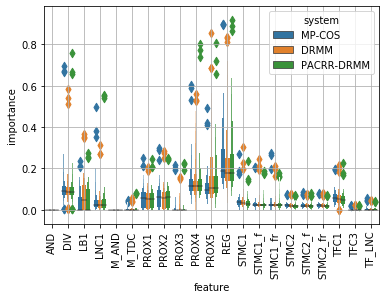

In [468]:
qrdm_fimp = feature_importances(qrdm_stats, query_system_rankdiff)
p = sns.boxenplot(data=qrdm_fimp, x='feature', y='importance', hue='system')
p.set_xticklabels(p.get_xticklabels(), rotation=90);
plt.grid()

# Including ranking-based features in a query-local model


## (a) only ranking difference

In [469]:
%%time
query_system = ['query', 'system']
features_with_ranking = col_predictors + ['rankdiff']
fit_qlrbf = mk_fit_fn(query_system, features=features_with_ranking)
qlrbf = dataset_sparkdf.groupby(query_system).apply(fit_qlrbf)
qlrbf_stats = qlrbf.drop('model').toPandas()
qlrbf_fimp = feature_importances(qlrbf_stats, query_system, features_with_ranking)

CPU times: user 88 ms, sys: 16 ms, total: 104 ms
Wall time: 1min 13s


In [470]:
record_fidelity_experiment(qlrbf_stats, 'loc_q+f-rd', 'Local', 'query', features=features_with_ranking)
qlrbf_stats.groupby('system').describe().T

system                                   DRMM       MP-COS   PACRR-DRMM
cv_accuracy_mean           count   100.000000   100.000000   100.000000
                           mean      0.663733     0.644190     0.702493
                           std       0.059446     0.067116     0.069959
                           min       0.563405     0.513503     0.559589
                           25%       0.616414     0.590704     0.648679
                           50%       0.659295     0.636840     0.709051
                           75%       0.702079     0.682999     0.750465
                           max       0.816243     0.821233     0.859270
cv_accuracy_std            count   100.000000   100.000000   100.000000
                           mean      0.016906     0.017319     0.015909
                           std       0.004234     0.004251     0.004429
                           min       0.007480     0.007445     0.007191
                           25%       0.013691     0.014443     0.012593
                           50%       0.016597     0.017202     0.015847
                           75%       0.019881     0.020486     0.018641
                           max       0.029744     0.028190     0.027310
avg_train_samples_per_fold count   100.000000   100.000000   100.000000
                           mean   9199.360352  9199.360352  9199.360352
                           std      52.122528    52.122528    52.122528
                           min    9192.000000  9192.000000  9192.000000
                           25%    9192.000000  9192.000000  9192.000000
                           50%    9192.000000  9192.000000  9192.000000
                           75%    9192.000000  9192.000000  9192.000000
                           max    9602.000000  9602.000000  9602.000000
avg_test_samples_per_fold  count   100.000000   100.000000   100.000000
                           mean   1022.820007  1022.820007  1022.820007
                           std       5.812526     5.812526     5.812526
                           min    1022.000000  1022.000000  1022.000000
                           25%    1022.000000  1022.000000  1022.000000
                           50%    1022.000000  1022.000000  1022.000000
                           75%    1022.000000  1022.000000  1022.000000
                           max    1068.000000  1068.000000  1068.000000

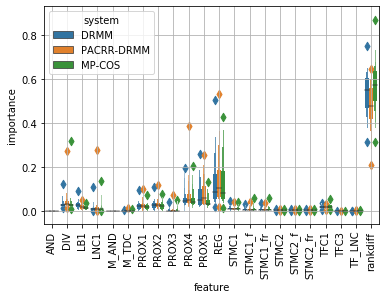

In [471]:
p = sns.boxenplot(data=qlrbf_fimp, x='feature', y='importance', hue='system')
p.set_xticklabels(p.get_xticklabels(), rotation=90);
plt.grid()

## (b) ranking difference plus position

In [472]:
%%time
group_key = ['query', 'system']
features_with_ranking = col_predictors + ['rankdiff', 'upper_rank']#, 'scorediff', 'upper_score']
fit_qlrbf = mk_fit_fn(group_key, features=features_with_ranking)
qlrbf = dataset_sparkdf.groupby(group_key).apply(fit_qlrbf)
qlrbf_stats = qlrbf.drop('model').toPandas()
qlrbf_fimp = feature_importances(qlrbf_stats, group_key, features_with_ranking)

CPU times: user 80 ms, sys: 20 ms, total: 100 ms
Wall time: 1min 53s


In [473]:
record_fidelity_experiment(qlrbf_stats, 'loc_q+f-rd+ur', 'Local', 'query', features=features_with_ranking)
qlrbf_stats.groupby('system').describe().T

system                                   DRMM       MP-COS   PACRR-DRMM
cv_accuracy_mean           count   100.000000   100.000000   100.000000
                           mean      0.731549     0.705976     0.760089
                           std       0.049124     0.056227     0.060711
                           min       0.632975     0.602642     0.638748
                           25%       0.689971     0.664628     0.710568
                           50%       0.735127     0.698483     0.760078
                           75%       0.763283     0.744129     0.801101
                           max       0.843933     0.849609     0.901966
cv_accuracy_std            count   100.000000   100.000000   100.000000
                           mean      0.015929     0.016288     0.016313
                           std       0.003552     0.004262     0.003849
                           min       0.008026     0.008314     0.008775
                           25%       0.013446     0.013562     0.013735
                           50%       0.015599     0.016121     0.015787
                           75%       0.018616     0.019629     0.018877
                           max       0.023110     0.025658     0.028977
avg_train_samples_per_fold count   100.000000   100.000000   100.000000
                           mean   9199.360352  9199.360352  9199.360352
                           std      52.122528    52.122528    52.122528
                           min    9192.000000  9192.000000  9192.000000
                           25%    9192.000000  9192.000000  9192.000000
                           50%    9192.000000  9192.000000  9192.000000
                           75%    9192.000000  9192.000000  9192.000000
                           max    9602.000000  9602.000000  9602.000000
avg_test_samples_per_fold  count   100.000000   100.000000   100.000000
                           mean   1022.820007  1022.820007  1022.820007
                           std       5.812526     5.812526     5.812526
                           min    1022.000000  1022.000000  1022.000000
                           25%    1022.000000  1022.000000  1022.000000
                           50%    1022.000000  1022.000000  1022.000000
                           75%    1022.000000  1022.000000  1022.000000
                           max    1068.000000  1068.000000  1068.000000

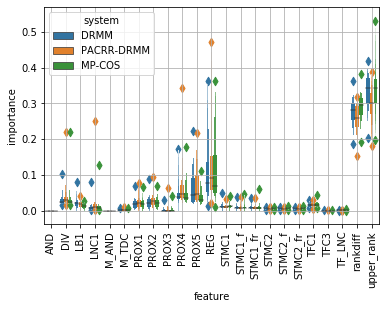

In [474]:
p = sns.boxenplot(data=qlrbf_fimp, x='feature', y='importance', hue='system')
p.set_xticklabels(p.get_xticklabels(), rotation=90);
plt.grid()

## (c) score difference plus upper_score

In [475]:
%%time
query_system = ['query', 'system']
features_with_ranking = col_predictors + ['scorediff', 'upper_score']
fit_qlrbf = mk_fit_fn(query_system, features=features_with_ranking)
qlrbf = dataset_sparkdf.groupby(query_system).apply(fit_qlrbf)
qlrbf_stats = qlrbf.drop('model').toPandas()
qlrbf_fimp = feature_importances(qlrbf_stats, query_system, features_with_ranking)

CPU times: user 92 ms, sys: 32 ms, total: 124 ms
Wall time: 1min 21s


In [476]:
record_fidelity_experiment(qlrbf_stats, 'loc_q+f-sd+us', 'Local', 'query', features=features_with_ranking)
qlrbf_stats.groupby('system').describe().T

system                                   DRMM       MP-COS   PACRR-DRMM
cv_accuracy_mean           count   100.000000   100.000000   100.000000
                           mean      0.734370     0.707845     0.763071
                           std       0.048668     0.056191     0.059446
                           min       0.648532     0.612427     0.651370
                           25%       0.695988     0.667784     0.713748
                           50%       0.735812     0.699706     0.766047
                           75%       0.767246     0.748116     0.802006
                           max       0.843346     0.845988     0.906180
cv_accuracy_std            count   100.000000   100.000000   100.000000
                           mean      0.016386     0.016116     0.015566
                           std       0.003572     0.003745     0.003808
                           min       0.006654     0.007747     0.007763
                           25%       0.013932     0.013798     0.012696
                           50%       0.016161     0.016110     0.015503
                           75%       0.019109     0.018440     0.018461
                           max       0.026606     0.026546     0.027505
avg_train_samples_per_fold count   100.000000   100.000000   100.000000
                           mean   9199.360352  9199.360352  9199.360352
                           std      52.122528    52.122528    52.122528
                           min    9192.000000  9192.000000  9192.000000
                           25%    9192.000000  9192.000000  9192.000000
                           50%    9192.000000  9192.000000  9192.000000
                           75%    9192.000000  9192.000000  9192.000000
                           max    9602.000000  9602.000000  9602.000000
avg_test_samples_per_fold  count   100.000000   100.000000   100.000000
                           mean   1022.820007  1022.820007  1022.820007
                           std       5.812526     5.812526     5.812526
                           min    1022.000000  1022.000000  1022.000000
                           25%    1022.000000  1022.000000  1022.000000
                           50%    1022.000000  1022.000000  1022.000000
                           75%    1022.000000  1022.000000  1022.000000
                           max    1068.000000  1068.000000  1068.000000

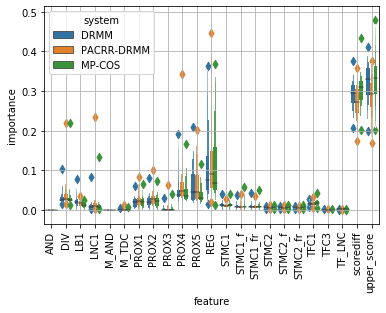

In [477]:
p = sns.boxenplot(data=qlrbf_fimp, x='feature', y='importance', hue='system')
p.set_xticklabels(p.get_xticklabels(), rotation=90);
plt.grid()

## (d) all ranking + score features

In [478]:
%%time
query_system = ['query', 'system']
features_with_ranking = col_predictors + ['rankdiff', 'upper_rank', 'scorediff', 'upper_score']
fit_qlrbf = mk_fit_fn(query_system, features=features_with_ranking)
qlrbf = dataset_sparkdf.groupby(query_system).apply(fit_qlrbf)
qlrbf_stats = qlrbf.drop('model').toPandas()
qlrbf_fimp = feature_importances(qlrbf_stats, query_system, features_with_ranking)

CPU times: user 80 ms, sys: 28 ms, total: 108 ms
Wall time: 2min 31s


In [479]:
record_fidelity_experiment(qlrbf_stats, 'loc_q+f-rd+ur+sd+us', 'Local', 'query', features=features_with_ranking)
qlrbf_stats.groupby('system').describe().T

system                                   DRMM       MP-COS   PACRR-DRMM
cv_accuracy_mean           count   100.000000   100.000000   100.000000
                           mean      0.746632     0.721210     0.772811
                           std       0.045709     0.050584     0.056507
                           min       0.659295     0.628082     0.653033
                           25%       0.709002     0.682436     0.727617
                           50%       0.751712     0.713405     0.773190
                           75%       0.774413     0.753743     0.812378
                           max       0.850391     0.852935     0.909270
cv_accuracy_std            count   100.000000   100.000000   100.000000
                           mean      0.016033     0.016045     0.015348
                           std       0.003593     0.004335     0.004217
                           min       0.007580     0.006149     0.007483
                           25%       0.013532     0.013234     0.012333
                           50%       0.016071     0.015097     0.015097
                           75%       0.018447     0.018418     0.017609
                           max       0.024910     0.028422     0.027828
avg_train_samples_per_fold count   100.000000   100.000000   100.000000
                           mean   9199.360352  9199.360352  9199.360352
                           std      52.122528    52.122528    52.122528
                           min    9192.000000  9192.000000  9192.000000
                           25%    9192.000000  9192.000000  9192.000000
                           50%    9192.000000  9192.000000  9192.000000
                           75%    9192.000000  9192.000000  9192.000000
                           max    9602.000000  9602.000000  9602.000000
avg_test_samples_per_fold  count   100.000000   100.000000   100.000000
                           mean   1022.820007  1022.820007  1022.820007
                           std       5.812526     5.812526     5.812526
                           min    1022.000000  1022.000000  1022.000000
                           25%    1022.000000  1022.000000  1022.000000
                           50%    1022.000000  1022.000000  1022.000000
                           75%    1022.000000  1022.000000  1022.000000
                           max    1068.000000  1068.000000  1068.000000

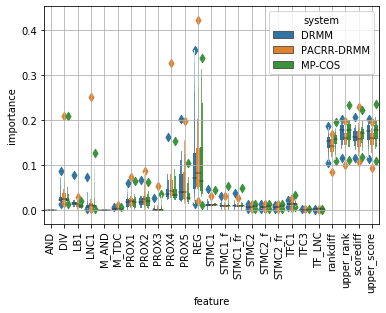

In [480]:
p = sns.boxenplot(data=qlrbf_fimp, x='feature', y='importance', hue='system')
p.set_xticklabels(p.get_xticklabels(), rotation=90);
plt.grid()

# Including ranking-based features in rank-diff local model

In [481]:
system_rankdiff = ['system', 'rankdiff_bin']

rd_udf = udf(lambda r: int(bin_edges.searchsorted(r)), returnType='byte')
features_with_ranking = col_predictors + ['rankdiff', 'upper_rank', 'scorediff', 'upper_score']

fit_binned = mk_fit_fn(system_rankdiff, features_with_ranking)

rdiff_models = dataset_sparkdf.withColumn('rankdiff_bin', rd_udf('rankdiff')).groupBy(system_rankdiff).apply(fit_binned)


In [482]:
%%time
rdm_stats = rdiff_models.drop('model').toPandas()

CPU times: user 72 ms, sys: 12 ms, total: 84 ms
Wall time: 1min 49s


In [483]:
record_fidelity_experiment(rdm_stats, 'loc_rd+f-rd+ur+sd+us', 'Local', 'rank-diff bin', features=features_with_ranking)
rdm_stats.groupby('system').describe().T

system                                    DRMM        MP-COS    PACRR-DRMM
cv_accuracy_mean           count     24.000000     24.000000     24.000000
                           mean       0.613522      0.589478      0.674826
                           std        0.064295      0.055757      0.079137
                           min        0.520232      0.503137      0.538139
                           25%        0.560506      0.546550      0.612819
                           50%        0.607817      0.584126      0.676231
                           75%        0.644649      0.622130      0.733662
                           max        0.768343      0.716545      0.824830
cv_accuracy_std            count     24.000000     24.000000     24.000000
                           mean       0.011730      0.009283      0.011848
                           std        0.003204      0.002185      0.004689
                           min        0.008008      0.003660      0.005586
                           25%        0.009178      0.008168      0.008505
                           50%        0.011224      0.009516      0.011121
                           75%        0.012950      0.010147      0.014128
                           max        0.021955      0.014807      0.027029
avg_train_samples_per_fold count     24.000000     24.000000     24.000000
                           mean   38302.035156  38302.035156  38302.031250
                           std     1139.444458   1139.444458   1139.444458
                           min    36238.800781  36238.800781  36238.800781
                           25%    37449.701172  37449.701172  37449.701172
                           50%    38096.400391  38096.400391  38096.400391
                           75%    39327.401367  39327.401367  39327.401367
                           max    40170.000000  40170.000000  40170.000000
avg_test_samples_per_fold  count     24.000000     24.000000     24.000000
                           mean    4290.383301   4290.383301   4290.383301
                           std      187.008087    187.008087    187.008087
                           min     4005.199951   4005.199951   4005.199951
                           25%     4119.299927   4119.299927   4119.299927
                           50%     4312.000000   4312.000000   4312.000000
                           75%     4330.449951   4330.449951   4330.449951
                           max     4717.600098   4717.600098   4717.600098

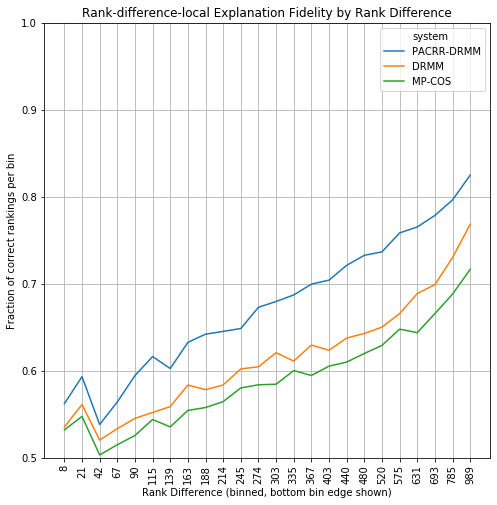

In [484]:
sns.lineplot(data=rdm_stats, x='rankdiff_bin', y='cv_accuracy_mean', hue='system')
bin_labels = ['%.0f'%x for x in bin_edges]
plt.xticks(np.arange(len(bin_labels)), bin_labels, rotation=90)
plt.xlabel('Rank Difference (binned, bottom bin edge shown)')
plt.ylabel('Fraction of correct rankings per bin')
plt.title('Rank-difference-local Explanation Fidelity by Rank Difference')
plt.ylim((0.5,1));
plt.gcf().set_size_inches((8,8))
plt.grid();

# Including ranking-based features in mixed model

[  1.      8.     21.     42.     67.     90.    115.    139.    163.
 188.    214.    245.    274.    303.    335.    367.275 403.    440.
 480.    520.    575.    631.    693.    785.    989.   ]
425.6 pairs per bin on average.


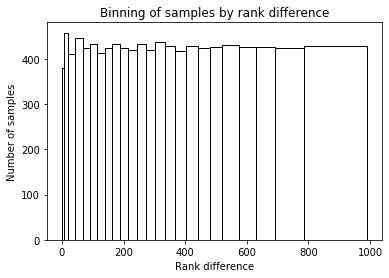

In [485]:
rdiffs = dataset_sparkdf.where('system = "DRMM" and query = 301').select('rankdiff').toPandas()
from scipy import stats
bin_edges = stats.mstats.mquantiles(
    rdiffs.rankdiff, np.linspace(0,1,25))
print(bin_edges)
plt.hist(rdiffs.rankdiff, bin_edges, color='w', edgecolor='k')
plt.title('Binning of samples by rank difference')
plt.xlabel('Rank difference')
plt.ylabel('Number of samples')
bin_edges = bin_edges[1:]
rdiffs['bin'] = rdiffs.rankdiff.map(lambda rd: bin_edges.searchsorted(rd))
print(f'{rdiffs.groupby("bin").count().mean().iloc[0]:.1f} pairs per bin on average.')

In [486]:
query_system_rankdiff = ['query', 'system', 'rankdiff_bin']
features_with_ranking = col_predictors + ['rankdiff', 'upper_rank', 'scorediff', 'upper_score']

rd_udf = udf(lambda r: int(bin_edges.searchsorted(r)), returnType='byte')

fit_binned = mk_fit_fn(query_system_rankdiff, features=features_with_ranking)

qdm_rf = dataset_sparkdf.withColumn('rankdiff_bin', rd_udf('rankdiff')).groupBy(query_system_rankdiff).apply(fit_binned)


In [487]:
%%time
qdm_rf_stats = qdm_rf.drop('model').toPandas()

CPU times: user 144 ms, sys: 36 ms, total: 180 ms
Wall time: 3min 20s


In [488]:
record_fidelity_experiment(qdm_rf_stats, 'loc_q_rd+f-rd+ur+sd+us', 'Local', 'query, rank-diff bin', features=features_with_ranking)
qdm_rf_stats.groupby('system').describe().T

system                                   DRMM       MP-COS   PACRR-DRMM
cv_accuracy_mean           count  2383.000000  2383.000000  2383.000000
                           mean      0.696253     0.668213     0.721035
                           std       0.125614     0.125243     0.135327
                           min       0.388636     0.397727     0.415909
                           25%       0.602273     0.576190     0.616667
                           50%       0.680952     0.647727     0.704545
                           75%       0.776732     0.738095     0.815909
                           max       1.000000     1.000000     1.000000
cv_accuracy_std            count  2383.000000  2383.000000  2383.000000
                           mean      0.077467     0.078982     0.074050
                           std       0.023909     0.023184     0.025295
                           min       0.000000     0.000000     0.000000
                           25%       0.062200     0.063636     0.058473
                           50%       0.077706     0.078893     0.075432
                           75%       0.092949     0.094761     0.091608
                           max       0.150224     0.162050     0.153959
avg_train_samples_per_fold count  2383.000000  2383.000000  2383.000000
                           mean    385.125458   385.125458   385.125458
                           std      41.492523    41.492523    41.492523
                           min      54.000000    54.000000    54.000000
                           25%     378.000000   378.000000   378.000000
                           50%     382.000000   382.000000   382.000000
                           75%     386.000000   386.000000   386.000000
                           max    1124.000000  1124.000000  1124.000000
avg_test_samples_per_fold  count  2383.000000  2383.000000  2383.000000
                           mean     43.837181    43.837181    43.837181
                           std       4.663344     4.663344     4.663344
                           min       6.000000     6.000000     6.000000
                           25%      42.000000    42.000000    42.000000
                           50%      44.000000    44.000000    44.000000
                           75%      44.000000    44.000000    44.000000
                           max     126.000000   126.000000   126.000000

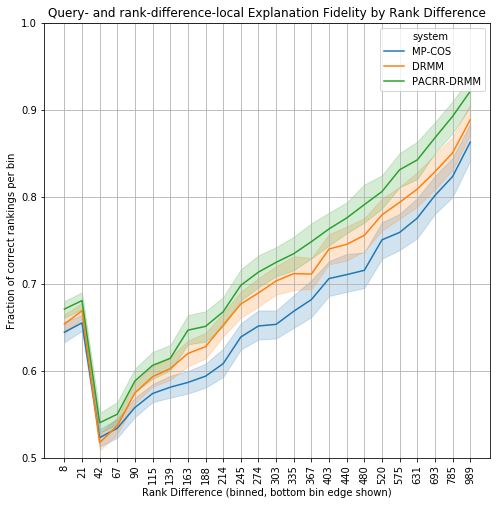

In [489]:
sns.lineplot(data=qdm_rf_stats, x='rankdiff_bin', y='cv_accuracy_mean', hue='system')
bin_labels = ['%.0f'%x for x in bin_edges]
plt.xticks(np.arange(len(bin_labels)), bin_labels, rotation=90)
plt.xlabel('Rank Difference (binned, bottom bin edge shown)')
plt.ylabel('Fraction of correct rankings per bin')
plt.title('Query- and rank-difference-local Explanation Fidelity by Rank Difference')
plt.ylim((0.5,1));
plt.gcf().set_size_inches((8,8))
plt.grid();

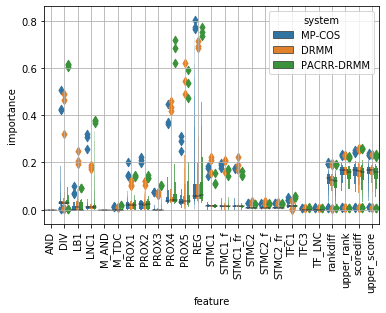

In [490]:
fimp = feature_importances(qdm_rf_stats, query_system_rankdiff, features_with_ranking)
p = sns.boxenplot(data=fimp, x='feature', y='importance', hue='system')
p.set_xticklabels(p.get_xticklabels(), rotation=90);
plt.grid()

# Binning by upper-rank

[  1.          20.         194.         280.         343.
 399.         439.         485.         524.         558.
 591.         621.         652.         684.         708.
 738.         763.         790.         818.         842.62307692
 866.         893.         917.         937.         958.
 979.         999.        ]
392.8 pairs per bin on average.


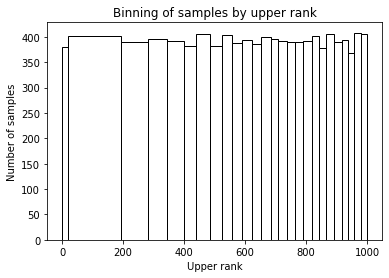

In [491]:
ranks = dataset_sparkdf.where('system = "DRMM" and query = 301').select('upper_rank').toPandas()
from scipy import stats
bin_edges = stats.mstats.mquantiles(
    ranks.upper_rank, np.linspace(0,1,27))
print(bin_edges)
plt.hist(ranks.upper_rank, bin_edges, color='w', edgecolor='k')
plt.title('Binning of samples by upper rank')
plt.xlabel('Upper rank')
plt.ylabel('Number of samples')
bin_edges = bin_edges[1:]
ranks['rank_bin'] = ranks.upper_rank.map(lambda rd: bin_edges.searchsorted(rd))
print(f'{ranks.groupby("rank_bin").count().mean().iloc[0]:.1f} pairs per bin on average.')

In [492]:
rank = ['system', 'rank_bin']
query_rank = ['query', 'system', 'rank_bin']
features_with_ranking = col_predictors + ['rankdiff', 'upper_rank', 'scorediff', 'upper_score']
features = col_predictors

rd_udf = udf(lambda r: int(bin_edges.searchsorted(r)), returnType='byte')

ds_with_bin = dataset_sparkdf.withColumn('rank_bin', rd_udf('upper_rank'))

r, r_rf, qr, qr_rf = [ds_with_bin.groupBy(gcols).apply(mk_fit_fn(gcols, feat)) 
                      for gcols, feat in
                      [(rank, features), (rank, features_with_ranking), (query_rank, features), (query_rank, features_with_ranking)]
                     ]

In [493]:
%%time
from multiprocessing.dummy import Pool
dfs = [r, r_rf, qr, qr_rf]
p = Pool(len(dfs))
r_stats, r_rf_stats, qr_stats, qr_rf_stats = p.map(lambda df: df.drop('model').toPandas(), dfs)

CPU times: user 400 ms, sys: 132 ms, total: 532 ms
Wall time: 2min 56s


## One model per upper-rank bin

In [494]:
record_fidelity_experiment(r_stats, 'loc_r', 'Local', 'upper-rank bin', features=features)
r_stats.groupby('system').describe().T

system                                    DRMM        MP-COS    PACRR-DRMM
cv_accuracy_mean           count     26.000000     26.000000     26.000000
                           mean       0.617561      0.594492      0.675448
                           std        0.021536      0.025799      0.023168
                           min        0.588597      0.554362      0.634566
                           25%        0.603230      0.577892      0.657554
                           50%        0.614350      0.590140      0.671305
                           75%        0.627744      0.606369      0.693398
                           max        0.678921      0.661815      0.718824
cv_accuracy_std            count     26.000000     26.000000     26.000000
                           mean       0.015559      0.013842      0.017861
                           std        0.004884      0.003734      0.005810
                           min        0.009170      0.008926      0.007353
                           25%        0.011799      0.010953      0.014634
                           50%        0.015290      0.013478      0.016211
                           75%        0.017241      0.015672      0.021163
                           max        0.031690      0.021552      0.035507
avg_train_samples_per_fold count     26.000000     26.000000     26.000000
                           mean   35302.277344  35302.277344  35302.277344
                           std     1893.022949   1893.022949   1893.022949
                           min    33320.000000  33320.000000  33320.000000
                           25%    33908.000000  33908.000000  33908.000000
                           50%    34888.000000  34888.000000  34888.000000
                           75%    35770.000000  35770.000000  35770.000000
                           max    40042.199219  40042.199219  40042.199219
avg_test_samples_per_fold  count     26.000000     26.000000     26.000000
                           mean    4013.800293   4013.799805   4013.799805
                           std      198.209534    198.209534    198.209534
                           min     3724.000000   3724.000000   3724.000000
                           25%     3920.000000   3920.000000   3920.000000
                           50%     3920.000000   3920.000000   3920.000000
                           75%     4116.000000   4116.000000   4116.000000
                           max     4525.799805   4525.799805   4525.799805

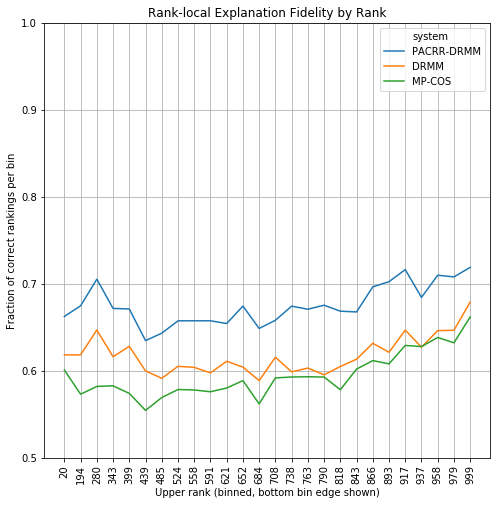

In [495]:
sns.lineplot(data=r_stats, x='rank_bin', y='cv_accuracy_mean', hue='system')
bin_labels = ['%.0f'%x for x in bin_edges]
plt.xticks(np.arange(len(bin_labels)), bin_labels, rotation=90)
plt.xlabel('Upper rank (binned, bottom bin edge shown)')
plt.ylabel('Fraction of correct rankings per bin')
plt.title('Rank-local Explanation Fidelity by Rank')
plt.ylim((0.5,1));
plt.gcf().set_size_inches((8,8))
plt.grid();

## One model per upper-rank bin with rank-dependent features

In [496]:
record_fidelity_experiment(r_rf_stats, 'loc_r+f-ur+rd+us+sd', 'Local', 'upper-rank bin', features=features_with_ranking)
r_rf_stats.groupby('system').describe().T

system                                    DRMM        MP-COS    PACRR-DRMM
cv_accuracy_mean           count     26.000000     26.000000     26.000000
                           mean       0.617663      0.594344      0.675351
                           std        0.021449      0.025618      0.023309
                           min        0.589031      0.554260      0.634184
                           25%        0.603820      0.577184      0.657758
                           50%        0.614031      0.589872      0.671583
                           75%        0.628496      0.606280      0.693273
                           max        0.679001      0.660714      0.719710
cv_accuracy_std            count     26.000000     26.000000     26.000000
                           mean       0.015693      0.013784      0.017799
                           std        0.005065      0.003701      0.005770
                           min        0.008885      0.008523      0.006374
                           25%        0.012063      0.011294      0.014209
                           50%        0.015611      0.013243      0.016442
                           75%        0.017805      0.015595      0.021100
                           max        0.031917      0.021835      0.035247
avg_train_samples_per_fold count     26.000000     26.000000     26.000000
                           mean   35302.277344  35302.277344  35302.277344
                           std     1893.022949   1893.022949   1893.022949
                           min    33320.000000  33320.000000  33320.000000
                           25%    33908.000000  33908.000000  33908.000000
                           50%    34888.000000  34888.000000  34888.000000
                           75%    35770.000000  35770.000000  35770.000000
                           max    40042.199219  40042.199219  40042.199219
avg_test_samples_per_fold  count     26.000000     26.000000     26.000000
                           mean    4013.800293   4013.799805   4013.799805
                           std      198.209534    198.209534    198.209534
                           min     3724.000000   3724.000000   3724.000000
                           25%     3920.000000   3920.000000   3920.000000
                           50%     3920.000000   3920.000000   3920.000000
                           75%     4116.000000   4116.000000   4116.000000
                           max     4525.799805   4525.799805   4525.799805

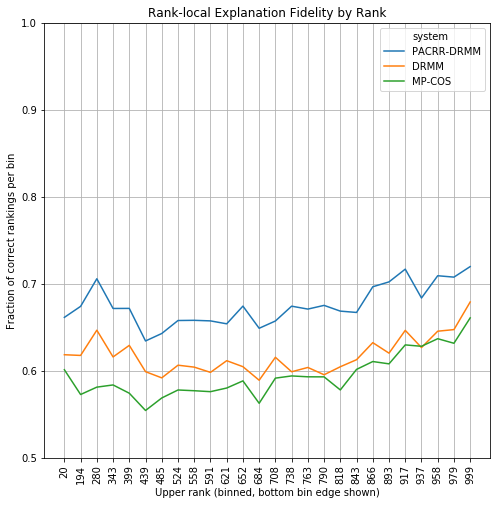

In [497]:
sns.lineplot(data=r_rf_stats, x='rank_bin', y='cv_accuracy_mean', hue='system')
bin_labels = ['%.0f'%x for x in bin_edges]
plt.xticks(np.arange(len(bin_labels)), bin_labels, rotation=90)
plt.xlabel('Upper rank (binned, bottom bin edge shown)')
plt.ylabel('Fraction of correct rankings per bin')
plt.title('Rank-local Explanation Fidelity by Rank')
plt.ylim((0.5,1));
plt.gcf().set_size_inches((8,8))
plt.grid();

## One model per (query, upper-rank bin) pair

In [498]:
record_fidelity_experiment(qr_stats, 'loc_q_r', 'Local', 'query, upper-rank bin', features=features)
qr_stats.groupby('system').describe().T

system                                   DRMM       MP-COS   PACRR-DRMM
cv_accuracy_mean           count  2558.000000  2558.000000  2558.000000
                           mean      0.704218     0.682571     0.731456
                           std       0.105197     0.103806     0.102324
                           min       0.397500     0.368421     0.445000
                           25%       0.627500     0.610000     0.655000
                           50%       0.695000     0.670000     0.727500
                           75%       0.774375     0.747589     0.805000
                           max       1.000000     0.997368     0.972549
cv_accuracy_std            count  2558.000000  2558.000000  2558.000000
                           mean      0.082805     0.084492     0.080208
                           std       0.023079     0.022567     0.021873
                           min       0.000000     0.007895     0.010266
                           25%       0.066883     0.068976     0.064991
                           50%       0.081927     0.084001     0.079646
                           75%       0.098139     0.098738     0.094901
                           max       0.179861     0.175784     0.160390
avg_train_samples_per_fold count  2558.000000  2558.000000  2558.000000
                           mean    358.709137   358.709137   358.709137
                           std     113.645966   113.645966   113.645966
                           min     330.000000   330.000000   330.000000
                           25%     344.000000   344.000000   344.000000
                           50%     354.000000   354.000000   354.000000
                           75%     360.000000   360.000000   360.000000
                           max    2976.000000  2976.000000  2976.000000
avg_test_samples_per_fold  count  2558.000000  2558.000000  2558.000000
                           mean     40.906960    40.906960    40.906960
                           std      12.623855    12.623855    12.623855
                           min      38.000000    38.000000    38.000000
                           25%      40.000000    40.000000    40.000000
                           50%      40.000000    40.000000    40.000000
                           75%      40.000000    40.000000    40.000000
                           max     332.000000   332.000000   332.000000

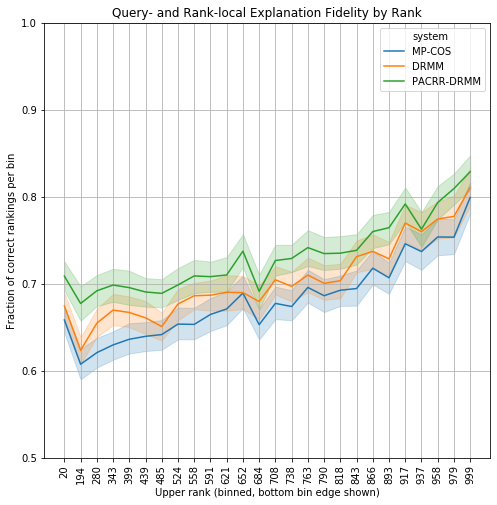

In [499]:
sns.lineplot(data=qr_stats, x='rank_bin', y='cv_accuracy_mean', hue='system')
bin_labels = ['%.0f'%x for x in bin_edges]
plt.xticks(np.arange(len(bin_labels)), bin_labels, rotation=90)
plt.xlabel('Upper rank (binned, bottom bin edge shown)')
plt.ylabel('Fraction of correct rankings per bin')
plt.title('Query- and Rank-local Explanation Fidelity by Rank')
plt.ylim((0.5,1));
plt.gcf().set_size_inches((8,8))
plt.grid();

## One model per (query, upper-rank bin) pair with rank-dependent features

In [500]:
record_fidelity_experiment(qr_rf_stats, 'loc_q_r+f-ur+rd+us+sd', 'Local', 'query, upper-rank bin', features=features_with_ranking)
qr_rf_stats.groupby('system').describe().T

system                                   DRMM       MP-COS   PACRR-DRMM
cv_accuracy_mean           count  2558.000000  2558.000000  2558.000000
                           mean      0.704337     0.682680     0.731339
                           std       0.105517     0.104029     0.102561
                           min       0.397500     0.376316     0.445238
                           25%       0.627500     0.610000     0.655000
                           50%       0.697500     0.672500     0.727500
                           75%       0.775000     0.750000     0.805000
                           max       1.000000     0.997368     0.975000
cv_accuracy_std            count  2558.000000  2558.000000  2558.000000
                           mean      0.083024     0.084424     0.080542
                           std       0.023042     0.022642     0.022082
                           min       0.000000     0.007895     0.010612
                           25%       0.067354     0.068237     0.065000
                           50%       0.082006     0.083516     0.079687
                           75%       0.098162     0.099656     0.094901
                           max       0.180624     0.179391     0.164792
avg_train_samples_per_fold count  2558.000000  2558.000000  2558.000000
                           mean    358.709137   358.709137   358.709137
                           std     113.645966   113.645966   113.645966
                           min     330.000000   330.000000   330.000000
                           25%     344.000000   344.000000   344.000000
                           50%     354.000000   354.000000   354.000000
                           75%     360.000000   360.000000   360.000000
                           max    2976.000000  2976.000000  2976.000000
avg_test_samples_per_fold  count  2558.000000  2558.000000  2558.000000
                           mean     40.906960    40.906960    40.906960
                           std      12.623855    12.623855    12.623855
                           min      38.000000    38.000000    38.000000
                           25%      40.000000    40.000000    40.000000
                           50%      40.000000    40.000000    40.000000
                           75%      40.000000    40.000000    40.000000
                           max     332.000000   332.000000   332.000000

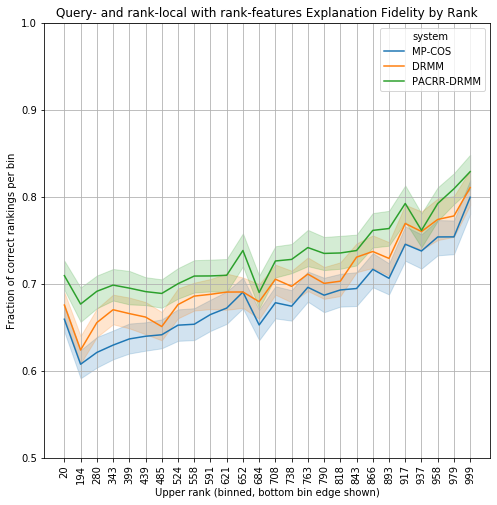

In [501]:
sns.lineplot(data=qr_rf_stats, x='rank_bin', y='cv_accuracy_mean', hue='system')
bin_labels = ['%.0f'%x for x in bin_edges]
plt.xticks(np.arange(len(bin_labels)), bin_labels, rotation=90)
plt.xlabel('Upper rank (binned, bottom bin edge shown)')
plt.ylabel('Fraction of correct rankings per bin')
plt.title('Query- and rank-local with rank-features Explanation Fidelity by Rank')
plt.ylim((0.5,1));
plt.gcf().set_size_inches((8,8))
plt.grid();